In [101]:
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import astropy.units as u
import scipy.integrate as integrate
import os, csv

def create_dir(filepath):
    if not os.path.exists(filepath):
        os.makedirs(filepath)

In [94]:
LAT_4fgldr4 = fits.open('BAT_LAT_match_4FGL_info.fits')
LAT_names = LAT_4fgldr4[1].data['LAT_NAME']
LAT_pref_spec = LAT_4fgldr4[1].data['SpectrumType']
LAT_Enorm = LAT_4fgldr4[1].data['Pivot_Energy']

#PWL params
LAT_PWL_idx = LAT_4fgldr4[1].data['PL_Index']
LAT_PWL_norm = LAT_4fgldr4[1].data['PL_Flux_Density']

#LogP params
LAT_LP_idx = LAT_4fgldr4[1].data['LP_Index']
LAT_LP_curv = LAT_4fgldr4[1].data['LP_beta']
LAT_LP_norm = LAT_4fgldr4[1].data['LP_Flux_Density']

#PWLCO
LAT_PWLCO_idx = LAT_4fgldr4[1].data['PLEC_IndexS']
LAT_PWLCO_norm = LAT_4fgldr4[1].data['PLEC_Flux_Density']
LAT_PWLCO_curv = LAT_4fgldr4[1].data['PLEC_ExpfactorS']
LAT_PWLCO_exp_idx = LAT_4fgldr4[1].data['PLEC_Exp_Index']

65


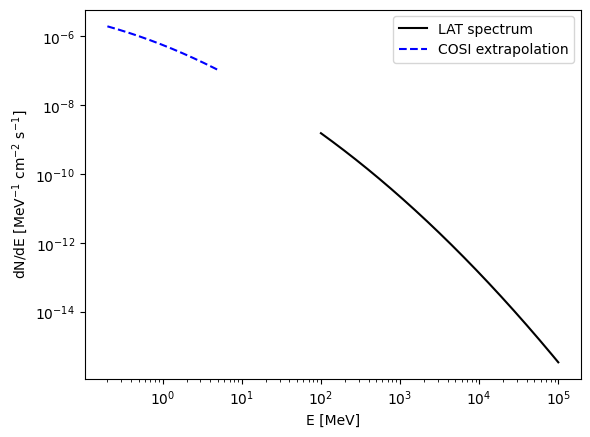

In [137]:
e_LAT = np.linspace(100,100000,100000)*u.MeV
e_COSI = np.linspace(0.2,5,100000)*u.MeV
LAT_spec=[]
COSI_spec=[]
create_dir('extrapolation_figures')

for i in range(len(LAT_names)):
    plt.close('all')
    name = LAT_names[i].replace(" ", "")
    pref_spec=LAT_pref_spec[i]
    e0=LAT_Enorm[i]*u.MeV
    
    if pref_spec=='PowerLaw':
        f0=LAT_PWL_norm[i]*u.Unit('MeV-1 cm-2 s-1')
        gamma=LAT_PWL_idx[i]
        
        f_LAT=f0*pow(e_LAT/e0,(-1)*gamma)
        f_COSI=f0*pow(e_COSI/e0,(-1)*gamma)
        LAT_spec.append(f_LAT)
        COSI_spec.append(f_COSI)
        
    elif pref_spec=='LogParabola':
        f0=LAT_LP_norm[i]*u.Unit('MeV-1 cm-2 s-1')
        gamma=LAT_LP_idx[i]
        beta=LAT_LP_curv[i]

        f_LAT=f0*pow(e_LAT/e0,(-1)*(gamma+beta*np.log(e_LAT/e0)))
        f_COSI=f0*pow(e_COSI/e0,(-1)*(gamma+beta*np.log(e_COSI/e0)))
        LAT_spec.append(f_LAT)
        COSI_spec.append(f_COSI)
        
    elif pref_spec=='PLSuperExpCutoff':
        f0=LAT_PWLCO_norm[i]*u.Unit('MeV-1 cm-2 s-1')
        gamma=LAT_PWLCO_idx[i]
        b=LAT_PWLCO_exp_idx[i]
        d=LAT_PWLCO_curv[i]

        f_LAT=f0*pow(e_LAT/e0,d/b-gamma)*np.exp((d/b**2)*(1-pow(e_LAT/e0,b)))
        f_COSI=f0*pow(e_COSI/e0,d/b-gamma)*np.exp((d/b**2)*(1-pow(e_COSI/e0,b)))
        LAT_spec.append(f_LAT)
        COSI_spec.append(f_COSI)

    plt.figure()
    plt.plot(e_LAT,f_LAT,'-k',label='LAT spectrum')
    plt.plot(e_COSI,f_COSI,'--b',label='COSI extrapolation')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('E [MeV]')
    plt.ylabel(r'dN/dE [MeV$^{-1}$ cm$^{-2}$ s$^{-1}$]')
    plt.legend(loc='best')
    plt.savefig('./extrapolation_figures/'+name+'_extrapolation.png',bbox_inches='tight')

LAT_spec = np.array(LAT_spec)
COSI_spec = np.array(COSI_spec)


Text(0.5, 0, 'Energy [MeV]')

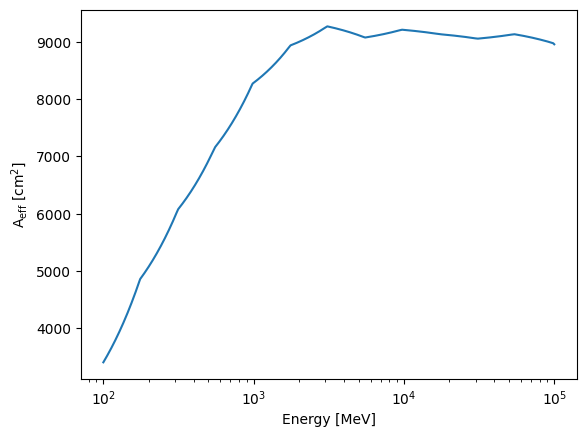

In [96]:
LAT_aeff=np.loadtxt('LAT_aeff.txt')
E_aeff_LAT=LAT_aeff[:,0]*u.MeV
aeff_LAT=LAT_aeff[:,1]*u.Unit('m2')
aeff_LAT=aeff_LAT.to('cm2')

f_interp_LAT = interp1d(E_aeff_LAT,aeff_LAT)
Aeff_LAT_interp = f_interp_LAT(e_LAT)*u.Unit('cm2')

plt.figure()
plt.plot(e_LAT, Aeff_LAT_interp)
plt.xscale('log')
#plt.ylim(0, 120)
plt.ylabel(r'A$_{\rm eff}$ [cm$^2$]')
plt.xlabel('Energy [MeV]')

Text(0.5, 0, 'Energy [MeV]')

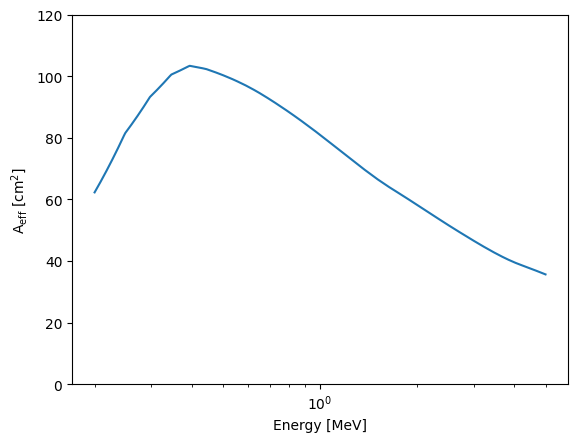

In [97]:
COSI_aeff=np.loadtxt('COSI_aeff.txt')
E_aeff_COSI=COSI_aeff[:,0]*u.keV
aeff_COSI=COSI_aeff[:,1]*u.Unit('cm2')
E_aeff_COSI=E_aeff_COSI.to('MeV')

f_interp_COSI = interp1d(E_aeff_COSI,aeff_COSI)
Aeff_COSI_interp = f_interp_COSI(e_COSI)*u.Unit('cm2')
 
plt.figure()
plt.plot(e_COSI, Aeff_COSI_interp)
plt.xscale('log')
plt.ylim(0, 120)
plt.ylabel(r'A$_{\rm eff}$ [cm$^2$]')
plt.xlabel('Energy [MeV]')

4FGL J0538.8-4405
LAT
0.0010282622276400382
COSI
0.00035352032751369397

4FGL J1104.4+3812
LAT
0.0011265388314620492
COSI
0.0013544831252091701

4FGL J1653.8+3945
LAT
0.0003318719990226938
COSI
0.0001416908406116467

4FGL J0136.5+3906
LAT
8.573171859757256e-05
COSI
4.515446227669516e-08

4FGL J0156.9-5301
LAT
1.2242113768531443e-05
COSI
1.1667257126497065e-07

4FGL J0244.6-5819
LAT
1.14994759893371e-05
COSI
9.290906798454575e-08

4FGL J0710.4+5908
LAT
9.250923770867895e-06
COSI
2.7230685865363372e-08

4FGL J1136.4+6736
LAT
1.5470072330920973e-05
COSI
2.495906874502263e-05

4FGL J1221.3+3010
LAT
0.00010478474209803799
COSI
1.5497047093159725e-05

4FGL J1800.6+7828
LAT
0.0006060425695376186
COSI
0.0012409798887744892

4FGL J2000.0+6508
LAT
0.0003020048665075422
COSI
9.251103975296016e-05

4FGL J2253.9+1609
LAT
0.0072670802748543775
COSI
0.0441032623763041

4FGL J2229.7-0832
LAT
0.0004111627877775087
COSI
0.0006670793528713254

4FGL J2147.3-7536
LAT
0.0003766774808668422
COSI
0.0005573434

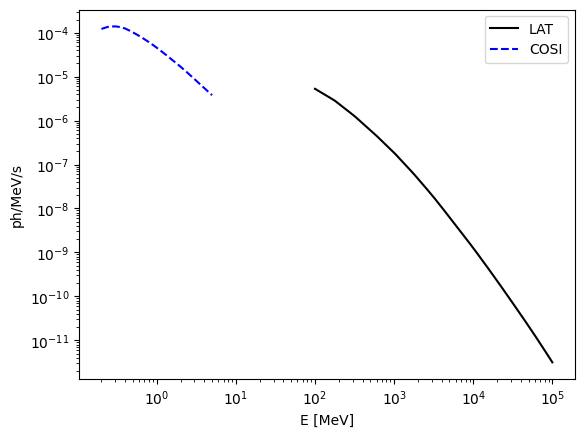

In [138]:
ph_flux_LAT_all=[]
ph_flux_COSI_all=[]
ratio_all=[]

for i in range(len(LAT_spec)):
    ph_flux_LAT=np.trapz(Aeff_LAT_interp.value * LAT_spec[i], e_LAT.value)
    ph_flux_LAT_all.append(ph_flux_LAT)
    print(LAT_names[i])
    print('LAT')
    print(ph_flux_LAT)
    
    ph_flux_COSI=np.trapz(Aeff_COSI_interp.value * COSI_spec[i], e_COSI.value)
    ph_flux_COSI_all.append(ph_flux_COSI)
    print('COSI')
    print(ph_flux_COSI)
    print('')

    plt.close('all')
    plt.plot(e_LAT,Aeff_LAT_interp.value * LAT_spec[i],'-k',label='LAT')
    plt.plot(e_COSI,Aeff_COSI_interp.value * COSI_spec[i],'--b',label='COSI')
    plt.xlabel('E [MeV]')
    plt.ylabel('ph/MeV/s')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.savefig('./extrapolation_figures/'+LAT_names[i]+'_ph_per_MeV_sec.png',bbox_inches='tight')
    
    ratio=ph_flux_COSI/ph_flux_LAT
    ratio_all.append(ratio)
    

In [139]:
av_aeff_scaled_lat=[]

for i in range(len(LAT_names)):
    plt.close('all')
    name = LAT_names[i].replace(" ", "")
    pref_spec=LAT_pref_spec[i]
    e0=LAT_Enorm[i]*u.MeV
    
    if pref_spec=='PowerLaw':
        f0=LAT_PWL_norm[i]*u.Unit('MeV-1 cm-2 s-1')
        gamma=LAT_PWL_idx[i]
        
        f_LAT=f0*pow(e_LAT/e0,(-1)*gamma)
        f_mean=np.mean(f_LAT)
        f_conv=f_LAT*Aeff_LAT_interp
        
        scaled_aeff=f_conv/f_mean
        av_aeff_scaled_lat.append(np.mean(scaled_aeff.value))
        
    elif pref_spec=='LogParabola':
        f0=LAT_LP_norm[i]*u.Unit('MeV-1 cm-2 s-1')
        gamma=LAT_LP_idx[i]
        beta=LAT_LP_curv[i]

        f_LAT=f0*pow(e_LAT/e0,(-1)*(gamma+beta*np.log(e_LAT/e0)))
        f_mean=np.mean(f_LAT)
        f_conv=f_LAT*Aeff_LAT_interp
        
        scaled_aeff=f_conv/f_mean
        av_aeff_scaled_lat.append(np.mean(scaled_aeff.value))
        
    elif pref_spec=='PLSuperExpCutoff':
        f0=LAT_PWLCO_norm[i]*u.Unit('MeV-1 cm-2 s-1')
        gamma=LAT_PWLCO_idx[i]
        b=LAT_PWLCO_exp_idx[i]
        d=LAT_PWLCO_curv[i]

        f_LAT=f0*pow(e_LAT/e0,d/b-gamma)*np.exp((d/b**2)*(1-pow(e_LAT/e0,b)))
        f_mean=np.mean(f_LAT)
        f_conv=f_LAT*Aeff_LAT_interp
        
        scaled_aeff=f_conv/f_mean
        av_aeff_scaled_lat.append(np.mean(scaled_aeff.value))

av_aeff_scaled_lat=np.array(av_aeff_scaled_lat)


In [140]:
av_aeff_scaled_cosi=[]

for i in range(len(LAT_names)):
    plt.close('all')
    name = LAT_names[i].replace(" ", "")
    pref_spec=LAT_pref_spec[i]
    e0=LAT_Enorm[i]*u.MeV
    
    if pref_spec=='PowerLaw':
        f0=LAT_PWL_norm[i]*u.Unit('MeV-1 cm-2 s-1')
        gamma=LAT_PWL_idx[i]
        
        f_COSI=f0*pow(e_COSI/e0,(-1)*gamma)
        f_mean=np.mean(f_COSI)
        f_conv=f_COSI*Aeff_COSI_interp
        
        scaled_aeff=f_conv/f_mean
        av_aeff_scaled_cosi.append(np.mean(scaled_aeff.value))
        
    elif pref_spec=='LogParabola':
        f0=LAT_LP_norm[i]*u.Unit('MeV-1 cm-2 s-1')
        gamma=LAT_LP_idx[i]
        beta=LAT_LP_curv[i]

        f_COSI=f0*pow(e_COSI/e0,(-1)*(gamma+beta*np.log(e_COSI/e0)))
        f_mean=np.mean(f_COSI)
        f_conv=f_COSI*Aeff_COSI_interp
        
        scaled_aeff=f_conv/f_mean
        av_aeff_scaled_cosi.append(np.mean(scaled_aeff.value))
        
    elif pref_spec=='PLSuperExpCutoff':
        f0=LAT_PWLCO_norm[i]*u.Unit('MeV-1 cm-2 s-1')
        gamma=LAT_PWLCO_idx[i]
        b=LAT_PWLCO_exp_idx[i]
        d=LAT_PWLCO_curv[i]

        f_COSI=f0*pow(e_COSI/e0,d/b-gamma)*np.exp((d/b**2)*(1-pow(e_COSI/e0,b)))
        f_mean=np.mean(f_COSI)
        f_conv=f_COSI*Aeff_COSI_interp
        
        scaled_aeff=f_conv/f_mean
        av_aeff_scaled_cosi.append(np.mean(scaled_aeff.value))

av_aeff_scaled_cosi=np.array(av_aeff_scaled_cosi)


In [141]:
filename = "COSI_LAT_factors.csv"

# Write to CSV
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Name", "ph/s_ratio", "Aeff_mean_LAT(cm2)", "Aeff_mean_COSI(cm2)"])  # Header

    for name, value, value2, value3 in zip(LAT_names, ratio_all, av_aeff_scaled_lat, av_aeff_scaled_cosi):
        writer.writerow([name, value, value2, value3]) 
